<a href="https://colab.research.google.com/github/Oughty-Otieno/Computer-vision-cnn/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement

The supermarket chain would like to explore whether Data Science can help them adhere to
alcohol laws by making sure they do not sell alcohol to people underage. You are asked to
conduct that evaluation, so as you set to work, keep the following in mind:

● The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

● Computer vision methods can be used to determine the age of a person from a photo.

● The task then is to build and evaluate a model for verifying people's age.

# Data loading and exploration

In [ ]:
#necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#load labels.csv and observe it
labels = pd.read_csv('/content/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


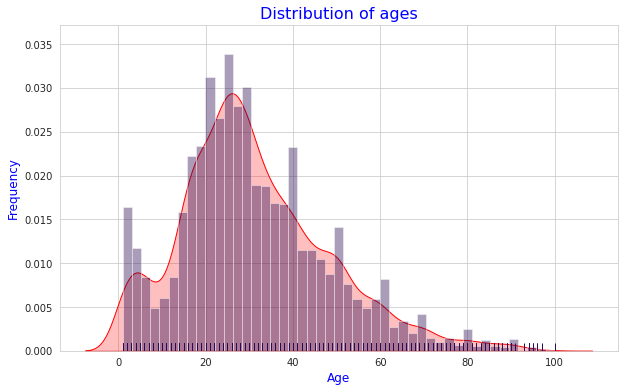

In [ ]:
#check the age distribution of photos

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


As we can see from the above plot, we have images of people of various ages. However, the majority of the images belong to 20-40 years old people. And also we have pretty much cute baby photos (less than 10).

In [ ]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/content/drive/MyDrive/Colab Notebooks/final_files',
    x_col="file_name", 
    y_col="real_age",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(224,224),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=12345,
    )

Found 7591 validated image filenames.


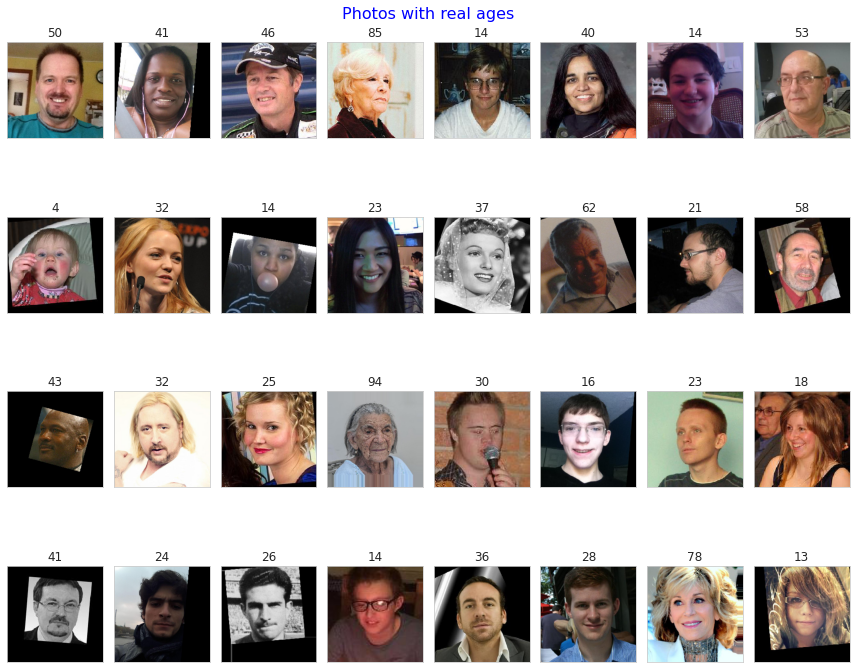

In [ ]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

# Modelling

In [ ]:
#Defining functions to be used 

def load_train():
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv('labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/MyDrive/Colab Notebooks/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test():
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv('labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/content/drive/MyDrive/Colab Notebooks/final_files',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

In [ ]:
#load training and testing (actually this is validation data set)
train_data = load_train()
test_data = load_test()

#build a model
model = create_model(input_shape = (224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
#train the model
model = train_model(model, train_data, test_data)

Epoch 1/20
178/178 - 4613s - loss: 10.5279 - mae: 10.5279 - val_loss: 13.4047 - val_mae: 13.4047 - 4613s/epoch - 26s/step
Epoch 2/20
178/178 - 75s - loss: 7.8925 - mae: 7.8925 - val_loss: 14.2484 - val_mae: 14.2484 - 75s/epoch - 419ms/step
Epoch 3/20
178/178 - 74s - loss: 6.6856 - mae: 6.6856 - val_loss: 13.5723 - val_mae: 13.5723 - 74s/epoch - 417ms/step
Epoch 4/20
178/178 - 74s - loss: 5.8233 - mae: 5.8233 - val_loss: 10.3263 - val_mae: 10.3263 - 74s/epoch - 418ms/step
Epoch 5/20
178/178 - 74s - loss: 5.3219 - mae: 5.3219 - val_loss: 7.5881 - val_mae: 7.5881 - 74s/epoch - 418ms/step
Epoch 6/20
178/178 - 74s - loss: 4.8978 - mae: 4.8978 - val_loss: 8.9971 - val_mae: 8.9971 - 74s/epoch - 417ms/step
Epoch 7/20
178/178 - 75s - loss: 4.5344 - mae: 4.5344 - val_loss: 6.7387 - val_mae: 6.7387 - 75s/epoch - 420ms/step
Epoch 8/20
178/178 - 74s - loss: 4.3460 - mae: 4.3460 - val_loss: 7.8344 - val_mae: 7.8344 - 74s/epoch - 418ms/step
Epoch 9/20
178/178 - 75s - loss: 3.9348 - mae: 3.9348 - val_

# Recommendations and observations


Our model managed to perform at an Mean Absolute error of 6.18, which is impressive.

The main challenge came when training. The 23587712 parameters took so much time despite using GPU runtime.